Running a simulation with SHyFT
=========

### This notebook is guiding through the simulation process of a catchment. The following steps are described in detail:
1. **Configuration of a SHyFT simulation run**
2. **Running a SHyFT simulation**
3. **Post-processing:** Fetching simulation results from the simulator-object.

<i>© Felix Matt, University of Oslo</i>

In [74]:
# python modules we use
%matplotlib inline
import os
import datetime
import sys
from matplotlib import pyplot as plt

##1. Configuration of a SHyFT simulation

* We use the **Simulator**-object in orchestration2/shyft_runner.py to conduct a calibration
* The settings of a simulation are set in the configuration files:
    
    * **configuration.yaml**:  
        * basic **configuration for the model run**
        * pointing to the other configuration-files
        * setting the time frame of the simulation (start date, step, nr of steps)
        * setting output variables and files
    
    * **model.yaml**
        * selection of the **model stack** (stack of sub-routines); in this example the PTGSK-stack:
            * **Priestley Taylor** for evapotranspiration
            * **GammaSnow** for handling of seasonal snow
            * **Kirchner-equation** for simulated discharge
        * setting the **model parameters**
    
    * **region.yaml**
        * points to **cell-data** database
    
    * **datasets.yaml**
        * points to **input time-series** database  
          each station must be specified (database as pure **data-container**)
        

In [75]:
# setting up the environment
shyft_path = os.path.abspath(os.path.realpath('../hycamp/project_shyft/shyft'))
sys.path.append(shyft_path)

In [76]:
 from shyft.orchestration2.shyft_runner import *

In [77]:
# set up configuration
config_file = "./atnsjoen_catchment/configuration.yaml"
config_section = "atnsjoen"
run_config = config_constructor(config_file, config_section)


In [78]:
# set up the simulator
simulator = Simulator(run_config)

In [79]:
# create a time axis
time_axis = api.Timeaxis(run_config.start_time, run_config.run_time_step, run_config.number_of_steps)

##2. Running a SHyFT simulation

In [80]:

# build the model
simulator.build_model(time_axis.start(), time_axis.delta(), time_axis.size())

1 wind_speed series found.
4 radiation series found.
2 precipitation series found.
2 temperature series found.
1 relative_humidity series found.
Done with model setup/interpolation step


In [81]:
# RUN THE MODEL!
simulator.run_model()

####EXERCISE 1:
Only one radiation station is found.
* Find out how many radiation time series the database provides.
You can use the [previous notebook](00_reading_shyft_database.ipynb) to do so.
* Change the dataset-configuration, so that the simulations takes the additional radiation-series into account.

##3. Post processing

###a) Fetching simulated discharge from the simulator-object

In [82]:
# get simulated time series of discharge

internal_id = simulator.catchment_map.index(1)
discharge_sim_obj = simulator.model.statistics.discharge(api.IntVector(0))
sim = [value for value in discharge_sim_obj.v]
sim_time = [discharge_sim_obj.time(i) for i in range(len(sim))]
sim_date = [datetime.datetime.utcfromtimestamp(t) for t in sim_time]

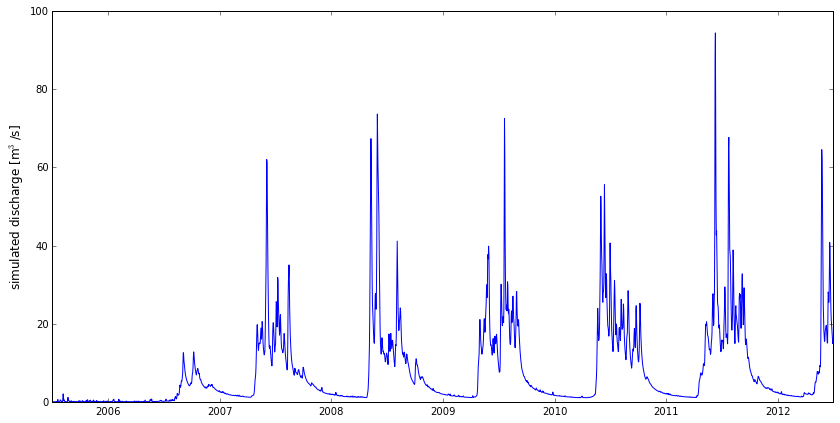

In [83]:
plt.figure(figsize=(14,7))
plt.plot(sim_date,sim)
plt.ylabel("simulated discharge [m$^3$/s]", fontsize=12)


###b) Fetching cell data from the simulator-object

In [84]:
# Fetching a list of cells
cells = simulator.model.statistics.cells

# getting the time axes of the simulation and generating a list of datetime-objects from it
ta = simulator.model.time_axis
start_date = datetime.datetime.utcfromtimestamp(ta.start())
dates = [start_date + datetime.timedelta(seconds=n*ta.delta()) for n in range(ta.size())]

# Collecting the time series of a response variable (e.g. the snow-covered-area (sca)) for each of the cells
sca_cells = []
sca_dates = []
start_idx = dates.index(datetime.datetime(2008,10,1))
for t in xrange(start_idx,start_idx+365): #one year of data
    sca_dates.append(dates[t])
    sca_cells.append([cell.rc.snow_sca.v[t] for cell in cells])
    
# fetching x- and y-location of the cells
x = [cell.geo.mid_point().x for cell in cells]
y = [cell.geo.mid_point().y for cell in cells]

/opt/anaconda/envs/py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


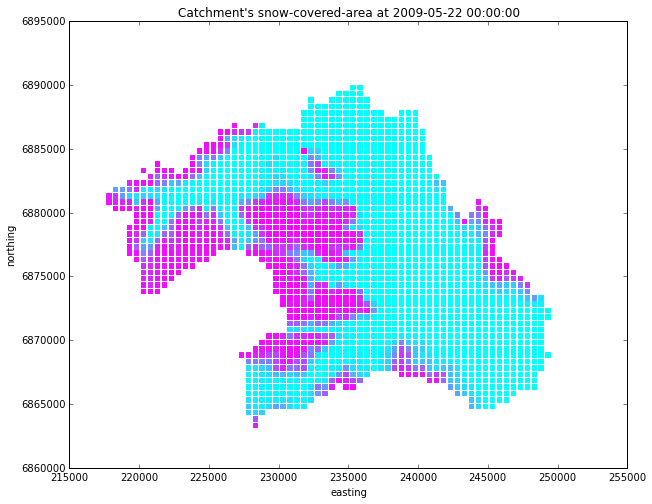

In [85]:
day_of_hyd_year = 233

plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('cool')
plt.scatter(x,y, color=cm(sca_cells[day_of_hyd_year]), marker = 's')
plt.xlabel("easting")
plt.ylabel("northing")
plt.title("Catchment's snow-covered-area at {}".format(sca_dates[day_of_hyd_year]))
